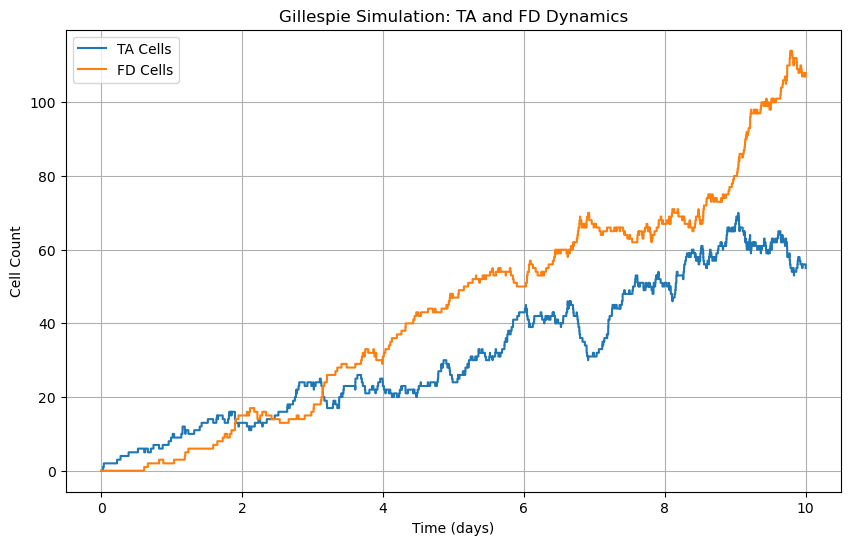

In [32]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
N0    = 18              # constant stem cell number
r     = 1 / (2.5 * 24)  # stem cell asymmetric division rate
lam   = 1 / 30          # TA cell symmetric division rate
d     = 0.0338          # TA differentiation rate
gamma = 1 / (3.5 * 24)  # FD apoptosis rate

def gillespie(Tmax):
    """
    Gillespie algorithm for the three-type branching process:
      1) S -> S + TA    at rate r*N0
      2) TA -> TA + TA  at rate lam * TA
      3) TA -> FD       at rate d * TA
      4) FD -> Ø        at rate gamma * FD
    """
    t = 0.0
    TA = 0
    FD = 0

    times = [t]
    TA_hist = [TA]
    FD_hist = [FD]

    while t < Tmax:
        # Calculate propensities
        a1 = r * N0
        a2 = lam * TA
        a3 = d * TA
        a4 = gamma * FD
        a0 = a1 + a2 + a3 + a4
        if a0 == 0:
            break

        # Time to next reaction
        dt = np.random.exponential(1 / a0)
        t += dt

        # Determine which reaction occurs
        rnum = np.random.rand() * a0
        if rnum < a1:
            # Stem produces TA
            TA += 1
        elif rnum < a1 + a2:
            # TA symmetric division
            TA += 1
        elif rnum < a1 + a2 + a3:
            # TA differentiation
            TA -= 1
            FD += 1
        else:
            # FD apoptosis
            FD -= 1

        # Record
        times.append(t)
        TA_hist.append(TA)
        FD_hist.append(FD)

    return np.array(times), np.array(TA_hist), np.array(FD_hist)

# Run simulation
Tmax = 240  # simulate for 240 hours (10 days)
times, TA_hist, FD_hist = gillespie(Tmax)

# Plot trajectories
plt.figure(figsize=(10,6))
plt.step(times / 24, TA_hist, where='post', label='TA Cells')
plt.step(times / 24, FD_hist, where='post', label='FD Cells')
plt.xlabel('Time (days)')
plt.ylabel('Cell Count')
plt.title('Gillespie Simulation: TA and FD Dynamics')
plt.legend()
plt.grid(True)
plt.show()

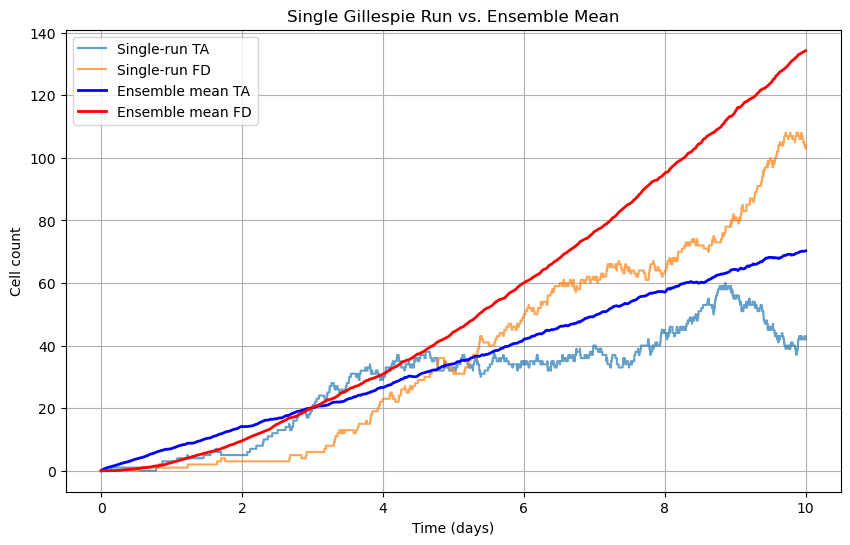

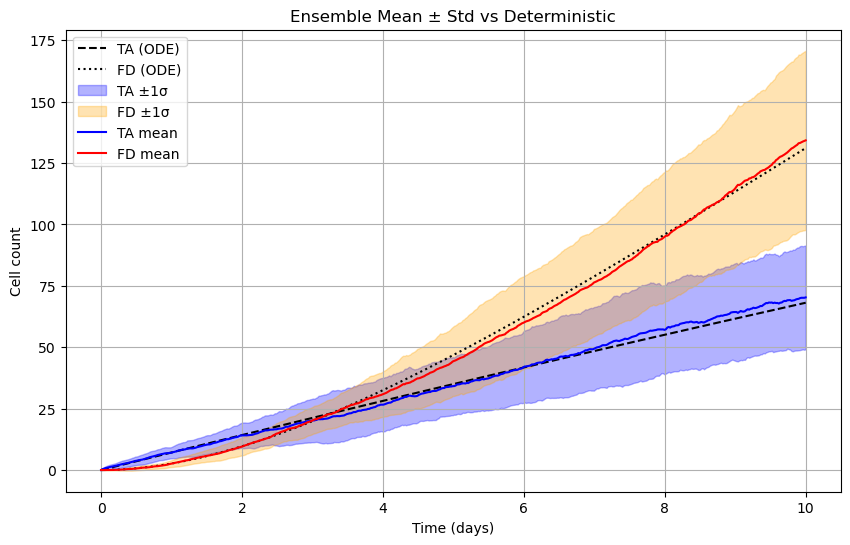

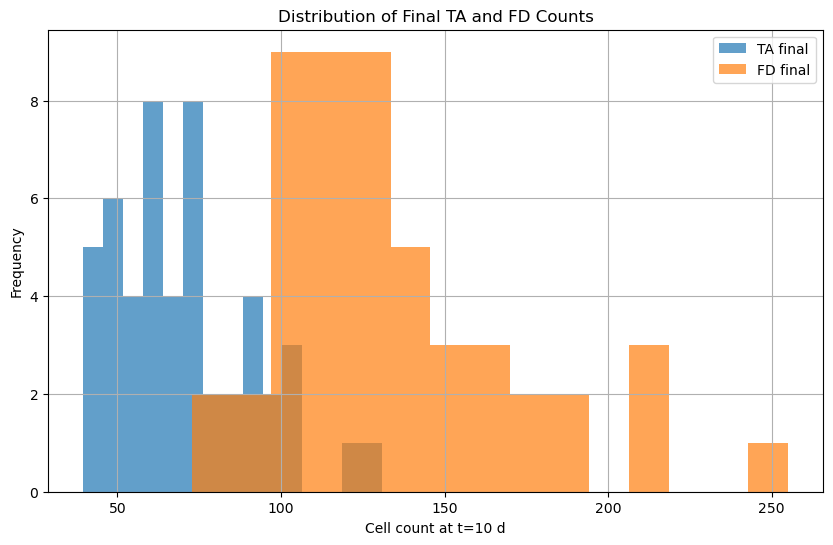

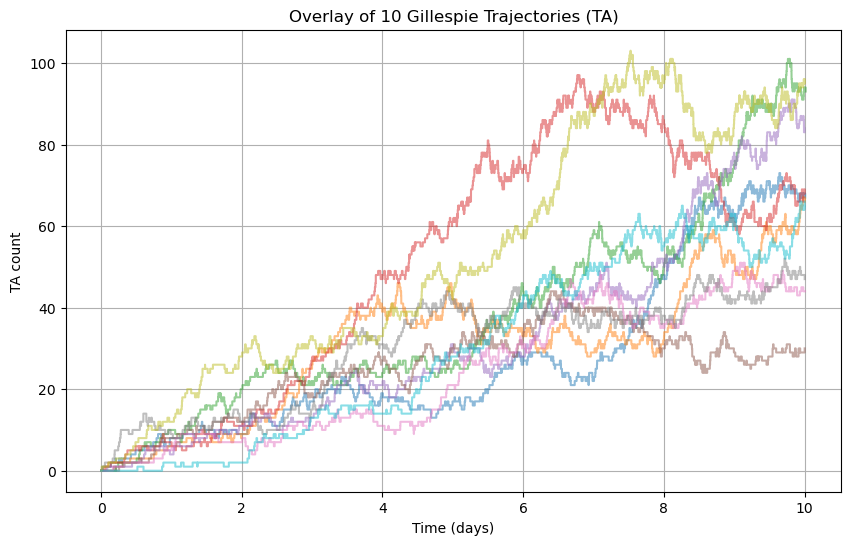

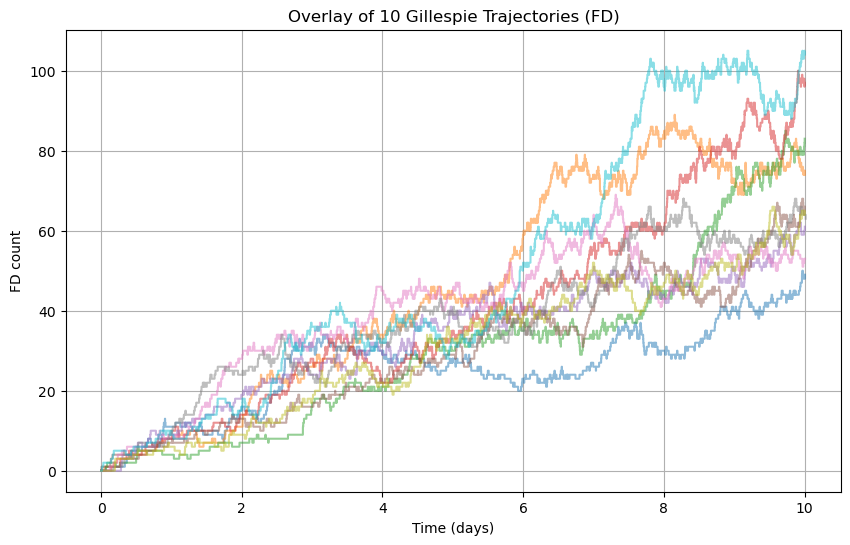

In [33]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

# Parameters
N0    = 18               # constant stem cell number
r     = 1 / (2.5 * 24)   # stem cell division rate (per hour)
lam   = 1 / 30           # TA cell division rate (per hour)
d     = 0.0338           # TA differentiation rate (per hour)
gamma = 1 / (3.5 * 24)   # FD cell apoptosis rate (per hour)

# Deterministic ODE model
def ode_model(t, y):
    TA, FD = y
    dTA = r * N0 + (lam - d) * TA
    dFD = d * TA - gamma * FD
    return [dTA, dFD]

# Gillespie simulator
def gillespie(Tmax):
    t, TA, FD = 0.0, 0, 0
    times, TA_hist, FD_hist = [t], [TA], [FD]
    while t < Tmax:
        # propensities
        a1 = r * N0
        a2 = lam * TA
        a3 = d * TA
        a4 = gamma * FD
        a0 = a1 + a2 + a3 + a4
        if a0 == 0:
            break
        # time step
        dt = np.random.exponential(1 / a0)
        t += dt
        # choose reaction
        u = np.random.rand() * a0
        if u < a1:
            TA += 1
        elif u < a1 + a2:
            TA += 1
        elif u < a1 + a2 + a3:
            TA -= 1
            FD += 1
        else:
            FD -= 1
        # record
        times.append(t)
        TA_hist.append(TA)
        FD_hist.append(FD)
    return np.array(times), np.array(TA_hist), np.array(FD_hist)

# Ensemble vs Deterministic
Tmax = 2400  # hours (10 days)
t_eval = np.linspace(0, Tmax, 500)

# run N simulations
n_sims = 50
TA_mat = np.zeros((n_sims, len(t_eval)))
FD_mat = np.zeros((n_sims, len(t_eval)))

for i in range(n_sims):
    times, TA_hist, FD_hist = gillespie(Tmax)
    TA_mat[i, :] = np.interp(t_eval, times, TA_hist)
    FD_mat[i, :] = np.interp(t_eval, times, FD_hist)

TA_mean, TA_std = TA_mat.mean(0), TA_mat.std(0)
FD_mean, FD_std = FD_mat.mean(0), FD_mat.std(0)

# deterministic solution
sol_det = solve_ivp(ode_model, (0, Tmax), [0, 0], t_eval=t_eval)

# Single Gillespie run overlaid with the ensemble mean
times, TA_hist, FD_hist = gillespie(Tmax)
plt.figure(figsize=(10,6))
plt.step(times/24, TA_hist, where='post', color='C0', alpha=0.7, label='Single-run TA')
plt.step(times/24, FD_hist, where='post', color='C1', alpha=0.7, label='Single-run FD')
plt.plot(t_eval/24, TA_mean, 'b-',    label='Ensemble mean TA', linewidth=2)
plt.plot(t_eval/24, FD_mean, 'r-',    label='Ensemble mean FD', linewidth=2)
plt.xlabel('Time (days)')
plt.ylabel('Cell count')
plt.title('Single Gillespie Run vs. Ensemble Mean')
plt.legend()
plt.grid(True)
plt.show()

# Plot mean ±1σ vs ODE
plt.figure(figsize=(10,6))
plt.plot(t_eval/24, sol_det.y[0], 'k--', label='TA (ODE)')
plt.plot(t_eval/24, sol_det.y[1], 'k:',  label='FD (ODE)')
plt.fill_between(t_eval/24, TA_mean-TA_std, TA_mean+TA_std, color='blue', alpha=0.3, label='TA ±1σ')
plt.fill_between(t_eval/24, FD_mean-FD_std, FD_mean+FD_std, color='orange', alpha=0.3, label='FD ±1σ')
plt.plot(t_eval/24, TA_mean, 'b', label='TA mean')
plt.plot(t_eval/24, FD_mean, 'r', label='FD mean')
plt.xlabel('Time (days)')
plt.ylabel('Cell count')
plt.title('Ensemble Mean ± Std vs Deterministic')
plt.legend()
plt.grid(True)
plt.show()

# Distribution of final counts
plt.figure(figsize=(10,6))
plt.hist(TA_mat[:, -1], bins=15, alpha=0.7, label='TA final')
plt.hist(FD_mat[:, -1], bins=15, alpha=0.7, label='FD final')
plt.xlabel('Cell count at t=10 d')
plt.ylabel('Frequency')
plt.title('Distribution of Final TA and FD Counts')
plt.legend()
plt.grid(True)
plt.show()

# Overlay of multiple trajectories (TA)
plt.figure(figsize=(10,6))
for _ in range(10):
    times, TA_hist, _ = gillespie(Tmax)
    plt.step(times/24, TA_hist, where='post', alpha=0.5)
plt.xlabel('Time (days)')
plt.ylabel('TA count')
plt.title('Overlay of 10 Gillespie Trajectories (TA)')
plt.grid(True)
plt.show()

# Overlay of multiple trajectories (FD)
plt.figure(figsize=(10,6))
for _ in range(10):
    times, FD_hist, _ = gillespie(Tmax)
    plt.step(times/24, FD_hist, where='post', alpha=0.5)
plt.xlabel('Time (days)')
plt.ylabel('FD count')
plt.title('Overlay of 10 Gillespie Trajectories (FD)')
plt.grid(True)
plt.show()

1. Single Gillespie Run vs. Ensemble Mean: shows how a single random trajectory fluctuates around the typical behavior captured by the mean.  

2. Ensemble Mean ± Std vs. Deterministic ODE: demonstrates that the stochastic average tracks the ODE solution, while highlighting the intrinsic noise spread in TA/FD counts.  

3. Distribution of Final TA and FD Counts: quantifies the variability in final population sizes, illustrating the range and most probable values for TA vs. FD under intrinsic stochasticity.  

4. Overlay of 10 Gillespie Trajectories (TA): visualizes the run‐to‐run variability and possible extremes in TA dynamics, showing how different realizations can diverge.  

5. Overlay of 10 Gillespie Trajectories (FD): similarly highlights stochastic variability in the FD compartment, comparing their noise with TA.

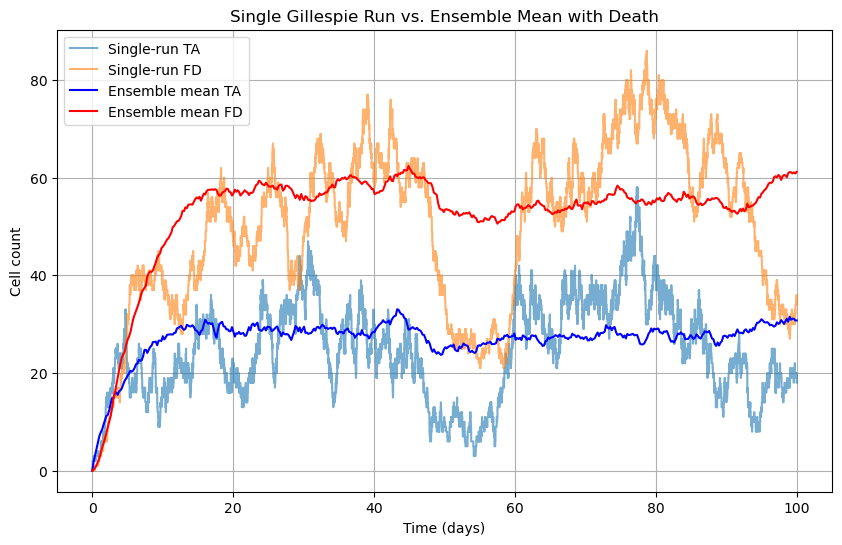

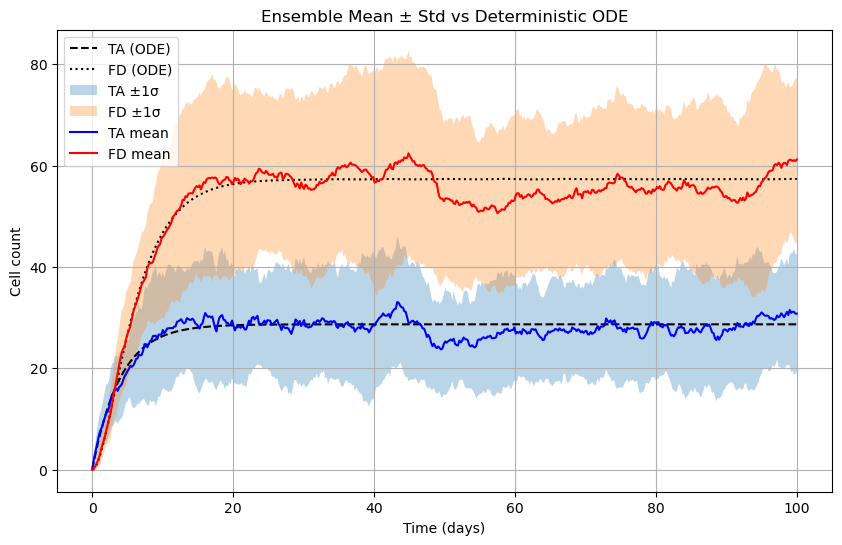

In [22]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

# Parameters
N0       = 18                # constant stem cell number
r        = 1 / (2.5 * 24)    # stem cell division rate (per hour)
lam      = 1 / 30            # TA cell division rate (per hour)
d        = 0.0338            # TA differentiation rate (per hour)
gamma    = 1 / (3.5 * 24)    # FD apoptosis rate (per hour)
delta_TA = 0.01              # TA cell death rate
delta_FD = 0.005             # FD cell additional death

def ode_model(t, y):
    TA, FD = y
    dTA = r * N0 + (lam - d - delta_TA) * TA
    dFD = d * TA - (gamma + delta_FD) * FD
    return [dTA, dFD]

def gillespie(Tmax):
    t, TA, FD = 0.0, 0, 0
    times, TA_hist, FD_hist = [t], [TA], [FD]
    t_abs = None

    while t < Tmax:
        # propensities
        a1 = r * N0
        a2 = lam * TA
        a3 = d * TA
        a4 = gamma * FD
        a5 = delta_TA * TA
        a6 = delta_FD * FD
        a0 = a1 + a2 + a3 + a4 + a5 + a6

        # next event
        dt = np.random.exponential(1 / a0)
        t += dt
        u = np.random.rand() * a0

        # which reaction?
        if u < a1:
            TA += 1
        elif u < a1 + a2:
            TA += 1
        elif u < a1 + a2 + a3:
            TA -= 1; FD += 1
        elif u < a1 + a2 + a3 + a4:
            FD -= 1
        elif u < a1 + a2 + a3 + a4 + a5:
            TA -= 1
        else:
            FD -= 1

        TA = max(TA, 0)
        FD = max(FD, 0)
        times.append(t)
        TA_hist.append(TA)
        FD_hist.append(FD)

        # record absorption time (first hit of TA=0 and FD=0)
        if TA == 0 and FD == 0 and t_abs is None:
            t_abs = t

    # if never absorbed, set to +inf
    if t_abs is None:
        t_abs = np.inf

    return np.array(times), np.array(TA_hist), np.array(FD_hist), t_abs

# Simulation settings
Tmax   = 2400    # hours (100 days)
t_eval = np.linspace(0, Tmax, 500)
n_sims = 50

TA_mat   = np.zeros((n_sims, len(t_eval)))
FD_mat   = np.zeros((n_sims, len(t_eval)))
t_absall = np.zeros(n_sims)

# run sims
for i in range(n_sims):
    times, TA_hist, FD_hist, t_abs = gillespie(Tmax)
    t_absall[i] = t_abs
    TA_mat[i, :] = np.interp(t_eval, times, TA_hist)
    FD_mat[i, :] = np.interp(t_eval, times, FD_hist)

# compute means and stds
TA_mean, TA_std = TA_mat.mean(0), TA_mat.std(0)
FD_mean, FD_std = FD_mat.mean(0), FD_mat.std(0)

# deterministic solution
sol_det = solve_ivp(ode_model, (0, Tmax), [0, 0], t_eval=t_eval)

# 1) your original plots
plt.figure(figsize=(10,6))
# single-run overlay
times, TA_hist, FD_hist, _ = gillespie(Tmax)
plt.step(times/24, TA_hist, where='post', alpha=0.6, label='Single-run TA')
plt.step(times/24, FD_hist, where='post', alpha=0.6, label='Single-run FD')
# ensemble mean
plt.plot(t_eval/24, TA_mean, 'b-', label='Ensemble mean TA')
plt.plot(t_eval/24, FD_mean, 'r-', label='Ensemble mean FD')
plt.xlabel('Time (days)')
plt.ylabel('Cell count')
plt.title('Single Gillespie Run vs. Ensemble Mean with Death')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10,6))
plt.plot(t_eval/24, sol_det.y[0], 'k--', label='TA (ODE)')
plt.plot(t_eval/24, sol_det.y[1], 'k:',  label='FD (ODE)')
plt.fill_between(t_eval/24, TA_mean-TA_std, TA_mean+TA_std, alpha=0.3, label='TA ±1σ')
plt.fill_between(t_eval/24, FD_mean-FD_std, FD_mean+FD_std, alpha=0.3, label='FD ±1σ')
plt.plot(t_eval/24, TA_mean, 'b', label='TA mean')
plt.plot(t_eval/24, FD_mean, 'r', label='FD mean')
plt.xlabel('Time (days)')
plt.ylabel('Cell count')
plt.title(f'Ensemble Mean ± Std vs Deterministic ODE')
plt.legend()
plt.grid(True)
plt.show()

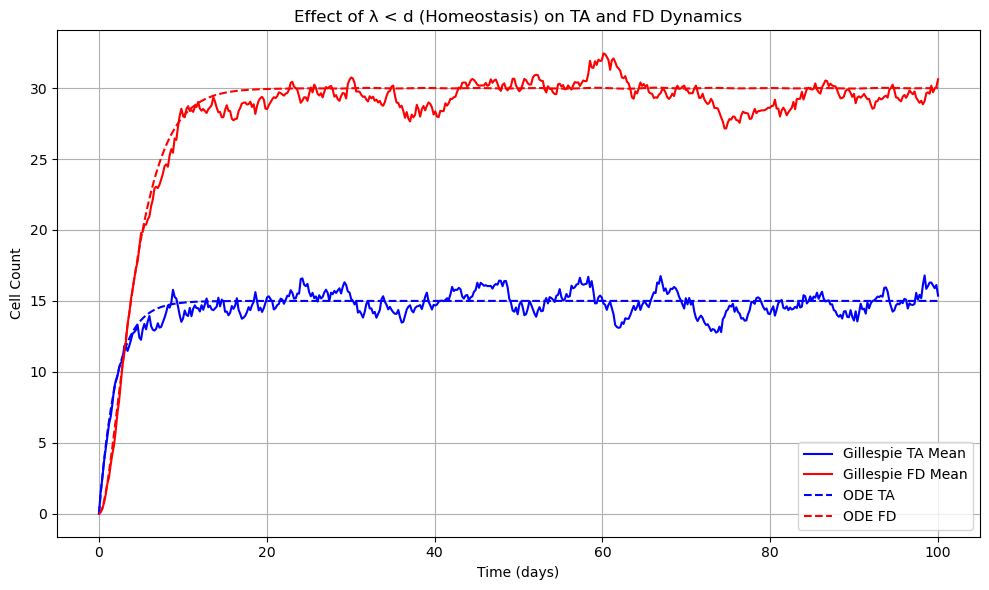

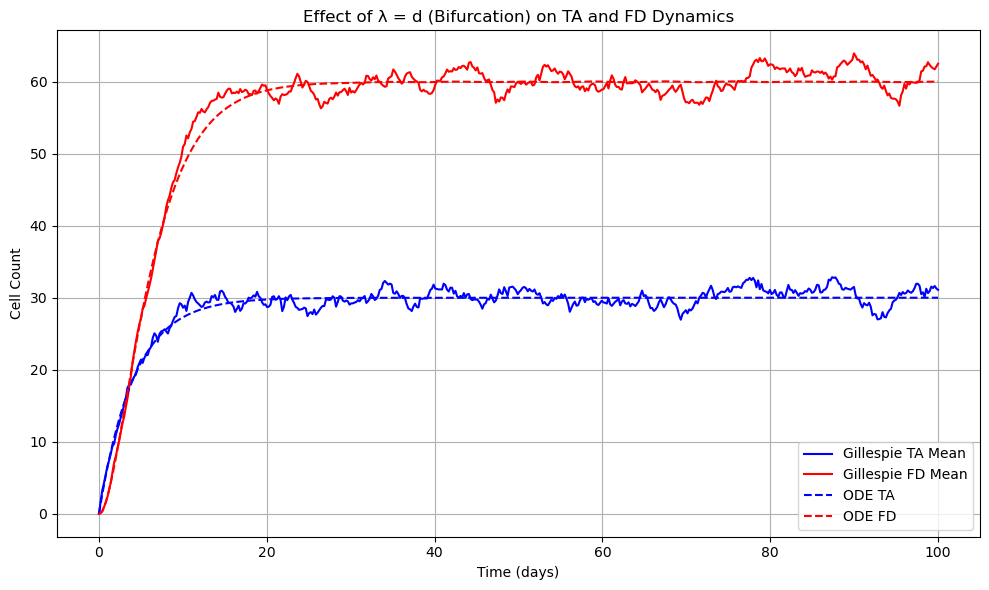

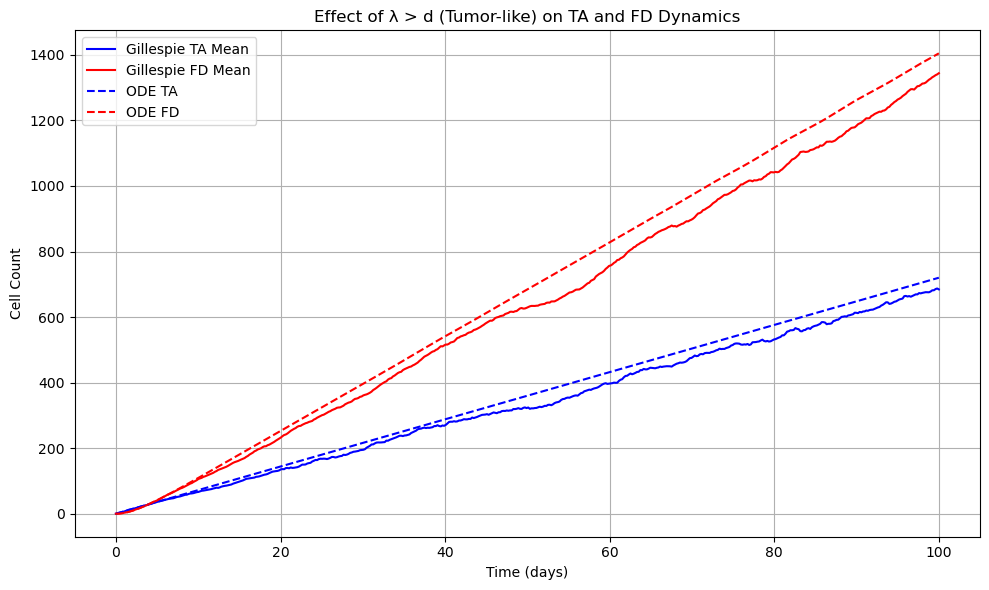

In [43]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

# Base parameters (per hour)
N0       = 18
r        = 1 / (2.5 * 24)
d        = 0.0338
gamma    = 1 / (3.5 * 24)
delta_TA = 0.01
delta_FD = 0.005

# Gillespie simulator (with death)
def gillespie(Tmax, lam):
    t, TA, FD = 0.0, 0, 0
    times, TA_hist, FD_hist = [t], [TA], [FD]
    while t < Tmax:
        a1 = r * N0
        a2 = lam * TA
        a3 = d * TA
        a4 = gamma * FD
        a5 = delta_TA * TA
        a6 = delta_FD * FD
        a0 = a1 + a2 + a3 + a4 + a5 + a6
        if a0 == 0:
            break
        dt = np.random.exponential(1 / a0)
        t += dt
        u = np.random.rand() * a0
        if u < a1:
            TA += 1
        elif u < a1 + a2:
            TA += 1
        elif u < a1 + a2 + a3:
            TA -= 1; FD += 1
        elif u < a1 + a2 + a3 + a4:
            FD -= 1
        elif u < a1 + a2 + a3 + a4 + a5:
            TA -= 1
        else:
            FD -= 1
        TA = max(TA, 0)
        FD = max(FD, 0)
        times.append(t)
        TA_hist.append(TA)
        FD_hist.append(FD)
    return np.array(times), np.array(TA_hist), np.array(FD_hist)

# ODE model
def ode_model(t, y, lam):
    TA, FD = y
    dTA = r * N0 + (lam - d - delta_TA) * TA
    dFD = d * TA - (gamma + delta_FD) * FD
    return [dTA, dFD]

# Simulation setup
Tmax = 2400  # hours (10 days)
t_eval = np.linspace(0, Tmax, 500)
lam_cases = {
    "λ < d (Homeostasis)": d - 0.01,
    "λ = d (Bifurcation)": d,
    "λ > d (Tumor-like)":  d + 0.01
}

# Run simulations for each case
for label, lam_val in lam_cases.items():
    # Run ODE
    sol_ode = solve_ivp(lambda t, y: ode_model(t, y, lam_val), (0, Tmax), [0, 0], t_eval=t_eval)

    # Run ensemble Gillespie
    n_sims = 50
    TA_mat = np.zeros((n_sims, len(t_eval)))
    FD_mat = np.zeros((n_sims, len(t_eval)))
    for i in range(n_sims):
        times, TA_hist, FD_hist = gillespie(Tmax, lam_val)
        TA_mat[i] = np.interp(t_eval, times, TA_hist)
        FD_mat[i] = np.interp(t_eval, times, FD_hist)
    TA_mean, FD_mean = TA_mat.mean(0), FD_mat.mean(0)

    # Plot
    plt.figure(figsize=(10, 6))
    plt.plot(t_eval/24, TA_mean, 'b', label='Gillespie TA Mean')
    plt.plot(t_eval/24, FD_mean, 'r', label='Gillespie FD Mean')
    plt.plot(t_eval/24, sol_ode.y[0], 'b--', label='ODE TA')
    plt.plot(t_eval/24, sol_ode.y[1], 'r--', label='ODE FD')
    plt.title(f'Effect of {label} on TA and FD Dynamics')
    plt.xlabel('Time (days)')
    plt.ylabel('Cell Count')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [35]:
import pandas as pd

d = 0.0338  # make sure this matches your model's d value
lam_settings = {
    "extinction": d - 0.01,
    "homeostasis": d,
    "growth": d + 0.01
}

def gillespie(Tmax, lam):
    t, TA, FD = 0.0, 0, 0
    times, TA_hist, FD_hist = [t], [TA], [FD]
    while t < Tmax:
        a1 = r * N0
        a2 = lam * TA
        a3 = d * TA
        a4 = gamma * FD
        a5 = delta_TA * TA
        a6 = delta_FD * FD
        a0 = a1 + a2 + a3 + a4 + a5 + a6
        if a0 == 0: break
        dt = np.random.exponential(1 / a0)
        t += dt
        u = np.random.rand() * a0
        if u < a1: TA += 1
        elif u < a1 + a2: TA += 1
        elif u < a1 + a2 + a3: TA -= 1; FD += 1
        elif u < a1 + a2 + a3 + a4: FD -= 1
        elif u < a1 + a2 + a3 + a4 + a5: TA -= 1
        else: FD -= 1
        TA, FD = max(TA, 0), max(FD, 0)
        times.append(t)
        TA_hist.append(TA)
        FD_hist.append(FD)
    return np.array(times), np.array(TA_hist), np.array(FD_hist)

# Simulate a small sample of Gillespie-based TA and FD cell trajectories
np.random.seed(0)
sample_data = []
sample_labels = []

for label, lam_val in lam_settings.items():
    for _ in range(5):  # 5 samples per class
        times, TA_hist, FD_hist = gillespie(Tmax=2400, lam=lam_val)
        TA_interp = np.interp(t_eval, times, TA_hist)
        FD_interp = np.interp(t_eval, times, FD_hist)
        row = np.concatenate([TA_interp, FD_interp])
        sample_data.append(row)
        sample_labels.append(label)

# Create a DataFrame
columns = [f'TA_t{i}' for i in range(len(t_eval))] + [f'FD_t{i}' for i in range(len(t_eval))]
df = pd.DataFrame(sample_data, columns=columns)
df['label'] = sample_labels

# Display the sample dataset
print(df.head())

# Optionally, save to CSV
df.to_csv("gillespie_sample_dataset.csv", index=False)

   TA_t0     TA_t1     TA_t2     TA_t3     TA_t4     TA_t5     TA_t6  \
0    0.0  1.858735  2.278773  2.934733  3.081891  1.783922  1.176139   
1    0.0  2.107685  5.569487  6.369662  5.517375  6.267115  6.227718   
2    0.0  3.696500  4.985529  4.305329  5.973790  4.921830  6.663630   
3    0.0  0.359916  0.719833  1.480835  3.060656  4.152040  5.336091   
4    0.0  1.873816  2.457161  2.107153  4.097086  4.693307  6.939210   

      TA_t7     TA_t8      TA_t9  ...    FD_t491    FD_t492    FD_t493  \
0  0.690052  2.955321   2.322374  ...  22.000000  22.779369  23.000000   
1  7.000000  7.800607   7.000000  ...  39.000000  40.147539  40.922861   
2  6.899716  7.689302   7.296957  ...  28.251884  29.464375  29.596539   
3  5.000000  6.727318  11.254629  ...  28.000000  27.000000  28.000000   
4  6.323091  5.570852   9.549608  ...  38.230898  36.000000  37.766928   

     FD_t494    FD_t495    FD_t496    FD_t497    FD_t498    FD_t499  \
0  24.861806  28.017474  29.000000  28.723501  31.9